In [2]:
from dotenv import dotenv_values
from backtester import Backtest
import pandas as pd
import numpy as np
from strategy import MlDt, StatisticalTest, StrategiesSignals
from binance.client import Client
import datetime
from dataset import Dataset

# Download data

In [3]:
data_binance = Dataset()
data = data_binance.get_data(days=90, ticker='SFPUSDT', ts='1H')

# Initialization strategy

In [4]:

strategy_ml = MlDt(threshold=0.003, name_strategy='ML DT', ticker='SFPUSDT', size=10)


## Create Rules for Mean Reversing strategy

In [5]:
strategy_ml._save_rules(
    data=data,
    rules=10
)

{'cumsum': 0.9158327295977993, 'mean': 0.0015112751313495038, 'median': 0.005306133146670833, 'count': 606, 'rules': {'sigma': 1, 'lag': 1, 'window_ma': 50, 'window_std': 100, 'day_of_week': [{'day_of_week': 0, 'mean': -0.00018081742968431723}, {'day_of_week': 1, 'mean': -2.88506392889451e-05}, {'day_of_week': 2, 'mean': 0.0004405665401480211}, {'day_of_week': 3, 'mean': -0.00034854625492320264}, {'day_of_week': 4, 'mean': 0.0008548832443592691}, {'day_of_week': 5, 'mean': 0.0006919790581612769}, {'day_of_week': 6, 'mean': 0.0018567696570927436}], 'hours': [{'hours': 0, 'mean': 0.0007532579160742337}, {'hours': 1, 'mean': 0.00172760030584839}, {'hours': 2, 'mean': 0.0009988448512678238}, {'hours': 3, 'mean': -0.00027104518397121405}, {'hours': 4, 'mean': 0.00181888504723694}, {'hours': 5, 'mean': 0.00031419817912773745}, {'hours': 6, 'mean': 0.0017915894237666818}, {'hours': 7, 'mean': 0.0011615902008558384}, {'hours': 8, 'mean': -0.0011960780577163252}, {'hours': 9, 'mean': 0.00027481

## Best rules for trading

In [6]:
best_rules = strategy_ml._best_rules()
print(best_rules)

{'sigma': 1, 'lag': 1, 'window_ma': 60, 'window_std': 100, 'day_of_week': [{'day_of_week': 0, 'mean': -0.00017836390917681105}, {'day_of_week': 1, 'mean': 0.00010321774583260321}, {'day_of_week': 2, 'mean': 0.0005200494142150046}, {'day_of_week': 3, 'mean': -0.00026907792435583905}, {'day_of_week': 4, 'mean': 0.000926334601396777}, {'day_of_week': 5, 'mean': 0.0009703095516639562}, {'day_of_week': 6, 'mean': 0.002011022158973567}], 'hours': [{'hours': 0, 'mean': 0.0008703721244961036}, {'hours': 1, 'mean': 0.0017883386930574623}, {'hours': 2, 'mean': 0.000918142916138444}, {'hours': 3, 'mean': -0.0002578658780571035}, {'hours': 4, 'mean': 0.002300125861024575}, {'hours': 5, 'mean': 6.997511903506359e-05}, {'hours': 6, 'mean': 0.00220188302342457}, {'hours': 7, 'mean': 0.001858270956653738}, {'hours': 8, 'mean': -0.001293802929950883}, {'hours': 9, 'mean': 0.00016262492602006154}, {'hours': 10, 'mean': 0.0014319780910084965}, {'hours': 11, 'mean': -0.00020815729776059815}, {'hours': 12,

2021-09-17 13:16:13.914 | INFO     | strategy:backtest:560 - Backtest using take profit method


<AxesSubplot:xlabel='time'>

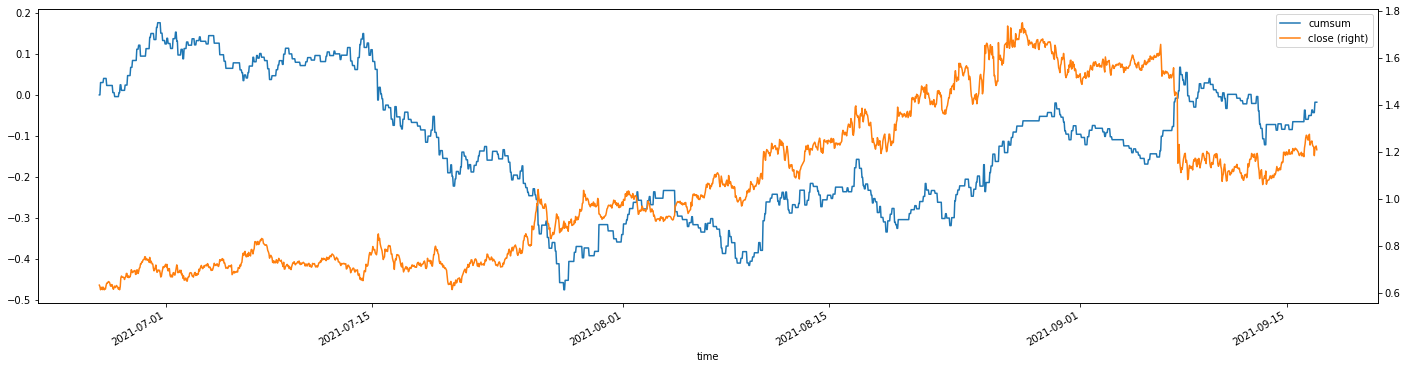

In [7]:
backtest_data = strategy_ml.backtest(data=data, comission=0.001,  takeProfit=0.01,
                lag=12, stopLoss=-0.005, exitPosition="take", ml=False)
backtest_data[['cumsum', 'close']].plot(figsize=(24, 6), secondary_y='close')

In [8]:
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] > 0, 1, backtest_data['return'])
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] < 0, -1, backtest_data['count_return'])
print(backtest_data.loc[backtest_data['count_return'] !=0, 'count_return'].value_counts(normalize=True))
print(backtest_data[backtest_data['return'] != 0]['signal'].value_counts(normalize=True))

-1.0    0.516129
 1.0    0.483871
Name: count_return, dtype: float64
 1    0.352535
-1    0.350230
 0    0.297235
Name: signal, dtype: float64


## Create Machine learning model

2021-09-17 13:16:41.286 | INFO     | strategy:backtest:560 - Backtest using take profit method
2021-09-17 13:16:44.023 | INFO     | strategy:backtest:560 - Backtest using take profit method


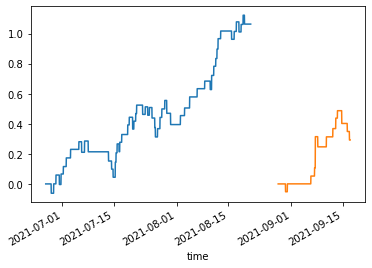

In [9]:
strategy_ml.create_machine_learning_models(data=data, split_train=0.7)

## Backtest

2021-09-17 13:17:03.221 | INFO     | strategy:backtest:560 - Backtest using take profit method


<AxesSubplot:xlabel='time'>

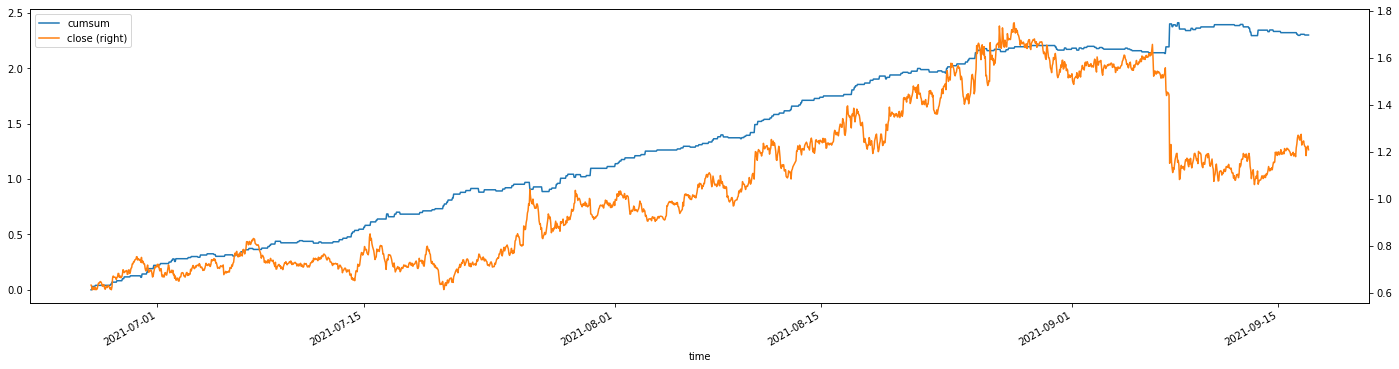

In [10]:
backtest_data = strategy_ml.backtest(data=data, comission=0.001,  takeProfit=0.01,
                lag=120, stopLoss=-0.005, exitPosition="take", ml=True)
backtest_data[['cumsum', 'close']].plot(figsize=(24, 6), secondary_y='close')

 1.0    0.728033
-1.0    0.271967
Name: count_return, dtype: float64
 0    0.719665
 1    0.175732
-1    0.104603
Name: signal, dtype: float64


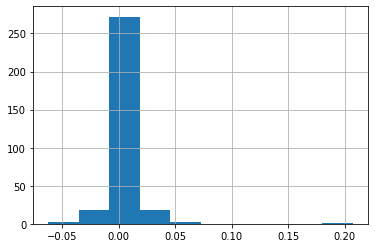

In [11]:
backtest_data[backtest_data['signal']!=0]['return'].hist()
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] > 0, 1, backtest_data['return'])
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] < 0, -1, backtest_data['count_return'])
print(backtest_data.loc[backtest_data['count_return'] !=0, 'count_return'].value_counts(normalize=True))
print(backtest_data[backtest_data['return'] != 0]['signal'].value_counts(normalize=True))

<AxesSubplot:xlabel='time'>

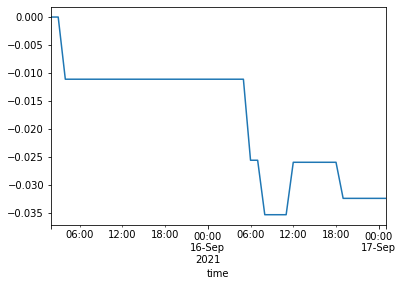

In [12]:
backtest_data.last('2D')['return'].cumsum().plot() # 1D, 1M, 1W, 5Min, 

# Test classic strategy Mean Reversing

You can not trade this strategy


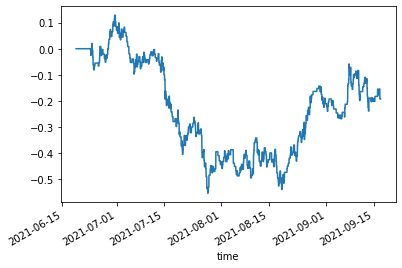

In [13]:
data.loc[:, 'signal'] = StrategiesSignals.mean_reversing(data, window=100)
back = Backtest()
backtest_data = back.exit_by_take(
    data=data,
    take_profit=0.01,
    stop_loss=-0.01,
    comission=0.001
)
backtest_data['cumsum'].plot()
# Statistical test
st_test = StatisticalTest.t_test(backtest_data[backtest_data['signal']!=0]['return'].values, backtest_data['close'].pct_change(1))
if st_test:
    print('You can trade this strategy')
if not st_test:
    print('You can not trade this strategy')

 1.0    0.538835
-1.0    0.461165
Name: count_return, dtype: float64
 1    0.412621
-1    0.368932
 0    0.218447
Name: signal, dtype: float64


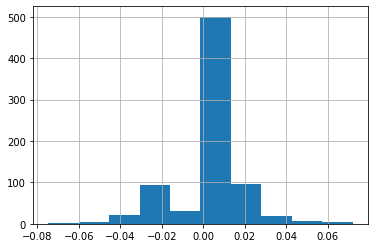

In [14]:
backtest_data[backtest_data['signal']!=0]['return'].hist()
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] > 0, 1, backtest_data['return'])
backtest_data.loc[:, 'count_return'] = np.where(backtest_data['return'] < 0, -1, backtest_data['count_return'])
print(backtest_data.loc[backtest_data['count_return'] !=0, 'count_return'].value_counts(normalize=True))
print(backtest_data[backtest_data['return'] != 0]['signal'].value_counts(normalize=True))

## Grange Test

In [ ]:
'''
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
'''
from statsmodels.tsa.stattools import grangercausalitytests
features = backtest_data[['close', 'open']].pct_change().dropna()
grange_test = pd.DataFrame(grangercausalitytests(features, 10))

### Testing new method before adding into strategy

In [ ]:
from strategy import StrategiesSignals

In [ ]:
data.loc[:, 'signal_mean_reversing'] = StrategiesSignals.mean_reversing(data, window=50)
data.loc[:, 'signal_momentun'] = StrategiesSignals.momentum(data['close'].values, seq=2)
# Check balance data. For machine learning we need balanced data
data['signal_mean_reversing'].value_counts(normalize=True)
data['signal_momentun'].value_counts(normalize=True)


### Backtesging automatic

In [28]:
take_profit_list = [0.005, 0.01, 0.02, 0.03, 0.04]
stop_loss_list = [-0.005, -0.01, -0.02, -0.03, -0.04]
best_mm = []
for t in take_profit_list:
    for s in stop_loss_list:
        backtest_data = strategy_ml.backtest(data=data, comission=0.001,  takeProfit=t,
                lag=12, stopLoss=-s, exitPosition="signal", ml=True)
        mm = {'profit': backtest_data['cumsum'].values[-1], 'take_profit': t, 'stop_loss': s}
        best_mm.append(mm)
        # backtest_data['cumsum'].plot()

2021-05-09 09:42:49.968 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:43:02.859 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:43:15.846 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:43:28.598 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:43:41.251 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:43:53.736 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:44:06.325 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:44:19.102 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:44:31.601 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:44:44.019 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09 09:44:56.642 | INFO     | strategy:backtest:541 - Backtest using signal method
2021-05-09